In [ ]:
#@title (OpenAI) Self-Tuning Prompt Optimization as Neural Network

# Install dependencies
!pip install -q openai pandas tqdm python-Levenshtein

# Imports & API key
import os, asyncio, pandas as pd, numpy as np, difflib, json
from tqdm.auto import tqdm
from openai import AsyncOpenAI
import nest_asyncio; nest_asyncio.apply()

os.environ["OPENAI_API_KEY"] = ""
client = AsyncOpenAI()

# Load CSV data
from google.colab import files
uploaded = files.upload()

df = pd.read_csv('training_data.csv')

# Helper Functions (Similarity Metric = Loss Function)
from Levenshtein import ratio as similarity_metric

def summarize_media_stub(url:str)->str:
    return f"Media at {url.split('/')[-1]}"

async def generate_reply(prompt, caption, media_desc, comment):
    user_prompt = f"{prompt}\n\nCaption: {caption}\nMedia: {media_desc}\nComment: {comment}\nReply:"
    resp = await client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[{"role":"system","content":"You're a social media assistant."},
                  {"role":"user","content":user_prompt}],
        temperature=0.2, max_tokens=100)
    return resp.choices[0].message.content.strip()

async def critique(gt, pred):
    prompt = f"Ideal reply: {gt}\nGenerated reply: {pred}\nCritique differences explicitly."
    resp = await client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[{"role":"system","content":"You're a strict evaluator."},
                  {"role":"user","content":prompt}],
        temperature=0.0, max_tokens=300)
    return resp.choices[0].message.content

async def tweak_prompt(prompt, critique, sim_before, sim_after=None):
    feedback = f"Similarity was {sim_before:.3f}."
    if sim_after:
        feedback += f" Your last change reduced similarity to {sim_after:.3f}. Fix it."
    meta_prompt = f"Current Prompt:\n{prompt}\n\nCritique:\n{critique}\n{feedback}\n\nSuggest small improvement (<40 words). Return new prompt only."
    resp = await client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[{"role":"system","content":"You're refining prompts based on numeric feedback."},
                  {"role":"user","content":meta_prompt}],
        temperature=0.3, max_tokens=500)
    return resp.choices[0].message.content.strip()

# Initial Prompt Generation (No initial prompt needed)
async def initial_prompt():
    resp = await client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[{"role":"system","content":"You're creating an initial prompt for social media comment replies."},
                  {"role":"user","content":"Generate a concise initial prompt template for responding to comments on posts, including style guidelines."}],
        temperature=0.3, max_tokens=300)
    return resp.choices[0].message.content.strip()

# Training Loop (Gradient Descent & Step Size Adjustment)
async def train_prompt(df, epochs=3, batch_size=5):
    prompt = await initial_prompt()
    print(f"\nInitial Prompt:\n{prompt}\n")

    for epoch in range(1, epochs+1):
        sims = []
        pbar = tqdm(range(0, len(df), batch_size), desc=f"Epoch {epoch}/{epochs}")

        for start in pbar:
            batch = df.iloc[start:start+batch_size]
            orig_sims, tweak_sims = [], []

            # Evaluate current prompt
            for _, row in batch.iterrows():
                media_desc = summarize_media_stub(row['media_url'])
                pred = await generate_reply(prompt, row['caption'], media_desc, row['comment'])
                orig_sims.append(similarity_metric(row['response'], pred))
                crit = await critique(row['response'], pred)

                # Propose and evaluate tweak
                candidate = await tweak_prompt(prompt, crit, np.mean(orig_sims))
                pred_tweak = await generate_reply(candidate, row['caption'], media_desc, row['comment'])
                tweak_sims.append(similarity_metric(row['response'], pred_tweak))

            # Accept-if-better rule (Gradient descent step)
            if np.mean(tweak_sims) > np.mean(orig_sims):
                prompt = candidate
                improvement = np.mean(tweak_sims) - np.mean(orig_sims)
                feedback = f"[+] Improved batch similarity {np.mean(orig_sims):.3f}→{np.mean(tweak_sims):.3f} (+{improvement:.3f})"
            else:
                # Rejection of worse prompt (Step size adjustment)
                feedback = f"No improvement ({np.mean(orig_sims):.3f}→{np.mean(tweak_sims):.3f}). Prompt unchanged."

            pbar.set_postfix_str(feedback)
            sims.append(np.mean(orig_sims))

        epoch_loss = 1 - np.mean(sims)
        print(f"Epoch {epoch} completed. Loss: {epoch_loss:.3f}\nPrompt at epoch {epoch}:\n{prompt}\n")

# Run Training
asyncio.run(train_prompt(df.head(100)))  # Adjust data size as needed


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 25.9 MB/s eta 0:00:00


Saving training_data.csv to training_data (1).csv

Initial Prompt:
**Comment Reply Template:**

---

**Prompt:**

"Thank you for your comment, [Name]! We appreciate your thoughts. [Personalized response related to their comment]. If you have any more questions or insights, feel free to share!"

---

**Style Guidelines:**

1. **Tone:** Friendly, approachable, and positive.
2. **Personalization:** Use the commenter’s name when possible.
3. **Engagement:** Encourage further interaction by inviting more questions or comments.
4. **Brevity:** Keep responses concise and to the point.
5. **Relevance:** Tailor the response to the specific comment to show genuine engagement.



Epoch 1/3:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1 completed. Loss: 0.767
Prompt at epoch 1:
"Hey [Name], thanks for your awesome comment on supercells! 🌪️ Lightning is truly amazing, isn't it? What do you find most fascinating about its raw power? ❤️"



Epoch 2/3:   0%|          | 0/20 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# Install dependencies
!pip install -q groq pandas tqdm python-Levenshtein openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.1/131.1 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 30.5 MB/s eta 0:00:00


In [ ]:
#@title 1 - Generate init prompt and test

import os, random, textwrap, pandas as pd
from openai import OpenAI
import numpy as np, json, math

os.environ["OPENAI_API_KEY"] = ""
CSV_PATH     = "/content/training_data.csv"
PROFILE_PATH = "/content/profile.txt"
N_EXEMPLARS  = 5
N_COMMENTS   = 5

# ---- Load data --------------------------------------------------
df       = pd.read_csv(CSV_PATH)
profile  = open(PROFILE_PATH).read().strip()

exemplars = df.sample(min(N_EXEMPLARS, len(df)), random_state=0)
ex_block  = "\n\n".join(
    f"Comment: {r.comment}\nReply: {r.response}" for _, r in exemplars.iterrows()
)

targets   = df.sample(min(N_COMMENTS, len(df)), random_state=99)
target_block = "\n".join(f"- {r.comment}" for _, r in targets.iterrows())

# ---- Define the function schema --------------------------------
tools = [{
    "type": "function",
    "function": {
        "name": "reply_to_comment",
        "description": "Return the persona-style reply to a single social-media comment.",
        "parameters": {
            "type": "object",
            "properties": {
                "comment": {"type": "string", "description": "Exact input comment"},
                "reply":   {"type": "string", "description": "Persona's reply, ≤50 words, emojis allowed"}
            },
            "required": ["comment", "reply"],
            "additionalProperties": False
        },
        "strict": True
    }
}]

# ---- Build system & user prompts --------------------------------
system_prompt = textwrap.dedent(f"""
    You are the social-media persona below.  Embody this voice completely:
    ===== PROFILE =====
    {profile}
    ===================
""").strip()

user_prompt = textwrap.dedent(f"""
    Here are example replies in your style:

    {ex_block}

    --------------------------
    NEW TASK
    Produce a reply for each of these comments (use function calls):
    {target_block}
""").strip()

# ---- Call the model --------------------------------------------
client = OpenAI()
completion = client.chat.completions.create(
    model = "gpt-4o-mini",
    messages = [
        {"role":"system","content":system_prompt},
        {"role":"user",  "content":user_prompt +
                    "\n\nINSTRUCTIONS: For **each** comment above, "
                    "return one `reply_to_comment` function call. "
                    "Do NOT reply with text, only tool calls."}
    ],
    tools       = tools,
    tool_choice = "required",          # must reply via function calls
)

tool_calls = completion.choices[0].message.tool_calls
tool_calls_raw = [tc.model_dump() for tc in tool_calls]
# print("Raw tool_calls:\n", json.dumps(tool_calls_raw, indent=2))

# ---- Parse results into list -----------------------------------
structured = [json.loads(tc["function"]["arguments"]) for tc in tool_calls_raw]
print("\nStructured replies:\n")
for obj in structured:
    print(f"COMMENT: {obj['comment']}\nREPLY  : {obj['reply']}\n")

# ---------- ground-truth lookup ---------------------------------
gt_lookup = { r.comment: r.response for _, r in targets.iterrows() }

# ---------- collect pairs --------------------------------------
pairs = []
for tc in tool_calls_raw:
    args = json.loads(tc["function"]["arguments"])
    cmt  = args["comment"]
    gen  = args["reply"]
    gt   = gt_lookup.get(cmt, "")
    pairs.append((gt, gen, cmt))

# ---------- embed everything in one shot -----------------------
flat_texts = [t for p in pairs for t in (p[0], p[1])]            # GT, GEN interleaved
emb_resp   = client.embeddings.create(
                 model="text-embedding-3-small",
                 input=flat_texts
             ).data
vecs = [np.array(e.embedding, dtype=np.float32) for e in emb_resp]

# ---------- compute & print ------------------------------------
print("\nCOMMENT / REPLY / COSINE SIM / DISTANCE\n"+"-"*50)
for i, (gt, gen, cmt) in enumerate(pairs):
    v_gt  = vecs[2*i]
    v_gen = vecs[2*i+1]
    cos   = float(np.dot(v_gt, v_gen) / (np.linalg.norm(v_gt)*np.linalg.norm(v_gen)))
    dist  = 1.0 - cos
    print(f"COMMENT : {cmt}\nGT REPLY: {gt}\nGEN REPLY: {gen}\n"
          f"cosine={cos:.3f}  distance={dist:.3f}\n")


Structured replies:

COMMENT: 😍
REPLY  : Love that excitement! 😍⚡️

COMMENT: I was about to ask.. is that real? 😆  mother nature movin for ya, giving you a show
REPLY  : @stormseeker22 Right?! Nature really knows how to put on a show! 🌪️🔥

COMMENT: I've seen one so skinny and slinky before.🌪️
REPLY  : @windchaser95 Those skinny twisters can be mesmerizing! 🌪️😍

COMMENT: As always please be careful my friends . supercell carry a whole new meaning now . stay safe .
REPLY  : @safetyfirst Always appreciate the concern! Staying alert and safe out there! 🙌🌩️

COMMENT: ❤️❤️
REPLY  : @lovewin Appreciate the love! ❤️⚡️


COMMENT / REPLY / COSINE SIM / DISTANCE
--------------------------------------------------
COMMENT : 😍
GT REPLY: @forbesricky yassssss 🙌
GEN REPLY: Love that excitement! 😍⚡️
cosine=0.285  distance=0.715

COMMENT : I was about to ask.. is that real? 😆  mother nature movin for ya, giving you a show
GT REPLY: @alissa.tenery84 Absolutely real! Nature’s wild show 🤘🏼⚡️
GEN REPLY: @s

In [ ]:
#@title 2 - Criritque prompt and outputs

# ---------- Build critique prompt ---------------------------------
DIST_THRESHOLD = 0.20

# Collect only the “misses”
misses = [
    {
        "comment": cmt,
        "ground_truth": gt,
        "generated": gen,
        "distance": dist
    }
    for (gt, gen, cmt), v_gt, v_gen, cos, dist in [
        (pairs[i], vecs[2*i], vecs[2*i+1],
         np.dot(vecs[2*i], vecs[2*i+1]) /
         (np.linalg.norm(vecs[2*i])*np.linalg.norm(vecs[2*i+1])),
         1 - np.dot(vecs[2*i], vecs[2*i+1]) /
         (np.linalg.norm(vecs[2*i])*np.linalg.norm(vecs[2*i+1])))
        for i in range(len(pairs))
    ]
    if dist > DIST_THRESHOLD
]

miss_block = "\n\n".join(
    textwrap.dedent(f"""
    Comment: {m['comment']}
    GT      : {m['ground_truth']}
    Generated: {m['generated']}
    Cos-distance: {m['distance']:.3f}
    """).strip()
    for m in misses
) or "(None above threshold)"

crit_system = (
    "You are a prompt-engineer and strict evaluator.\n"
    "Task A: For every pair with cosine distance > 0.20, "
    "explain succinctly why the generated reply diverged.\n"
    "Task B: Inspect the *entire* user_prompt below and propose "
    "specific edits (wording, exemplar tweaks, additional rules) "
    "that would steer the model closer to the ground truth. "
    "Return ONE consolidated critique."
)

crit_user = textwrap.dedent(f"""
===== USER_PROMPT USED =====
{user_prompt}
============================

===== MISMATCHED REPLIES (>0.20) =====
{miss_block}
======================================


Return suggested changes to the user prompt used based on the mismatched replies. Your goal is to presetve as much of the original prompt as possible, however you aslo want to make adjustments, changes and additions to it in order to get the generated comment closest to the ground truth. With this, you can use examples from the mismatches along with the ground truth and make specific comments about each.
""").strip()

crit_resp = client.chat.completions.create(
    model     = "gpt-4.1",
    messages  = [
        {"role":"system","content":crit_system},
        {"role":"user",  "content":crit_user}
    ],
    temperature = 0.2,
    max_tokens  = 2000
)

print("\n=== CRITIQUE & PROMPT SUGGESTIONS ===\n")
print(crit_resp.choices[0].message.content.strip())



=== CRITIQUE & PROMPT SUGGESTIONS ===

**Task A: Divergence Explanations**

1. **Comment: 😍**
   - *Divergence*: The generated reply is generic and does not tag the commenter, while the GT reply tags the user and uses a more enthusiastic, personalized expression ("yassssss 🙌"). The generated lacks both the tag and the heightened excitement.
2. **Comment: I was about to ask.. is that real? 😆 mother nature movin for ya, giving you a show**
   - *Divergence*: The generated reply tags a different user, uses a rhetorical "Right?!" and is less direct in confirming authenticity. The GT reply directly affirms ("Absolutely real!") and uses a more stylized, energetic tone.
3. **Comment: I've seen one so skinny and slinky before.🌪️**
   - *Divergence*: The generated reply uses "mesmerizing" and a different user tag, while the GT reply acknowledges the specific attribute ("Skinny ones have their own kind of power") and uses a more grounded, appreciative tone.
4. **Comment: As always please be car

In [ ]:
#@title 3 - Generate prompt diff based on critique

# ---------- Generate prompt diff based on critique --------------
diff_system = (
    "You are a prompt-engineer bot. Your job is to output a *unified diff* "
    "that transforms the ORIGINAL prompt into an IMPROVED prompt that "
    "incorporates the critique suggestions.  Output ONLY the diff — no "
    "extra commentary."
)

diff_user = textwrap.dedent(f"""
ORIGINAL_PROMPT
<<<
{user_prompt}
>>>

CRITIQUE_SUGGESTIONS
<<<
{crit_resp.choices[0].message.content.strip()}
>>>

Please produce a git-style unified diff (--- / +++) showing only the lines
that change.  Keep placeholders {{caption}}, {{media}}, {{comment}} intact.
""").strip()

diff_resp = client.chat.completions.create(
    model     = "gpt-4.1",
    messages  = [
        {"role":"system","content":diff_system},
        {"role":"user",  "content":diff_user}
    ],
    temperature = 0.0,
    max_tokens  = 2000
)

patch = diff_resp.choices[0].message.content.strip()
print("\n=== DIFF PATCH ===\n")
print(patch)



=== DIFF PATCH ===

--- ORIGINAL_PROMPT
+++ IMPROVED_PROMPT
@@
-Here are example replies in your style:
+Here are example replies in your style:
@@
-    --------------------------
-    NEW TASK
-    Produce a reply for each of these comments (use function calls):
-    - 😍
-- I was about to ask.. is that real? 😆  mother nature movin for ya, giving you a show
-- I've seen one so skinny and slinky before.🌪️
-- As always please be careful my friends . supercell carry a whole new meaning now . stay safe .
-- ❤️❤️
+--------------------------
+NEW TASK
+Produce a reply for each of these comments (use function calls):
+- 😍
+- I was about to ask.. is that real? 😆  mother nature movin for ya, giving you a show
+- I've seen one so skinny and slinky before.🌪️
+- As always please be careful my friends . supercell carry a whole new meaning now . stay safe .
+- ❤️❤️
+
+--------------------------
+Additional Instructions:
+
+- Always begin your reply by tagging the original commenter using their hand

In [ ]:
#@title 4 - Merge Diff

# -----------------------------------------------------------------
# 1.  APPLY THE UNIFIED-DIFF PATCH TO BUILD merged_prompt
# -----------------------------------------------------------------
def apply_unified_diff(original: str, diff_text: str) -> str:
    """
    Apply a minimal unified-diff patch. Lines beginning with ``` are ignored,
    so markdown-wrapped diffs won't break the parser.
    """
    orig_lines = original.splitlines()
    new_lines  = []
    idx = 0
    for raw in diff_text.splitlines():
        line = raw.rstrip("\n")
        if line.startswith(("```", "---", "+++", "@@")) or line == "":
            continue                      # skip fences & headers
        if line.startswith(" "):
            new_lines.append(orig_lines[idx]); idx += 1
        elif line.startswith("-"):
            idx += 1                      # delete the original line
        elif line.startswith("+"):
            new_lines.append(line[1:])    # insert new line (strip '+')
        else:
            # Anything else is treated as context (keep original)
            new_lines.append(line)
    new_lines.extend(orig_lines[idx:])    # append untouched tail
    return "\n".join(new_lines)

merged_prompt = apply_unified_diff(user_prompt, patch)
print("\n=== MERGED PROMPT ===\n", merged_prompt, "\n")

# -----------------------------------------------------------------
# 2.  RE-RUN GENERATION WITH merged_prompt
# -----------------------------------------------------------------
# rebuild the completion call with the *same* targets list
completion2 = client.chat.completions.create(
    model = "gpt-4o-mini",
    messages = [
        {"role":"system","content":system_prompt},
        {"role":"user",  "content": merged_prompt +
            "\n\nINSTRUCTIONS: For **each** comment below, "
            "return one `reply_to_comment` function call. "
            "Do NOT reply with text, only tool calls.\n\n" +
            target_block}
    ],
    tools       = tools,
    tool_choice = "required",
)

tc2   = [tc.model_dump() for tc in completion2.choices[0].message.tool_calls]
pairs2 = []
for tc in tc2:
    args = json.loads(tc["function"]["arguments"])
    pairs2.append((gt_lookup[args["comment"]], args["reply"], args["comment"]))

# -----------------------------------------------------------------
# 3.  EMBED AND COMPUTE DISTANCES AGAIN
# -----------------------------------------------------------------
flat2     = [t for p in pairs2 for t in (p[0], p[1])]
emb2_resp = client.embeddings.create(model="text-embedding-3-small",
                                     input=flat2).data
vec2 = [np.array(e.embedding, dtype=np.float32) for e in emb2_resp]

dists_old, dists_new = [], []
print("\nCOMMENT / OLD vs NEW DISTANCE\n"+"-"*60)
for i, ((gt, old_gen, cmt), (_, new_gen, _)) in enumerate(zip(pairs, pairs2)):
    v_old = vecs[2*i+1]   # old generated vec
    v_gt  = vecs[2*i]     # same GT vec
    v_new = vec2[2*i+1]   # new generated vec

    cos_old = float(np.dot(v_gt, v_old) /
                    (np.linalg.norm(v_gt)*np.linalg.norm(v_old)))
    cos_new = float(np.dot(v_gt, v_new) /
                    (np.linalg.norm(v_gt)*np.linalg.norm(v_new)))
    dist_old, dist_new = 1-cos_old, 1-cos_new
    dists_old.append(dist_old); dists_new.append(dist_new)
    tag = "[+]" if dist_new < dist_old else "[-]"
    print(f"{tag} COMMENT: {cmt[:40]}…\n"
          f"old_dist={dist_old:.3f} → new_dist={dist_new:.3f}\n")

avg_old = sum(dists_old)/len(dists_old)
avg_new = sum(dists_new)/len(dists_new)
print(f"\nAverage distance  OLD {avg_old:.3f} → NEW {avg_new:.3f}")
if avg_new < avg_old - 1e-4:
    print("Merged prompt improved overall similarity!")
else:
    print("No overall improvement (or little change).")



=== MERGED PROMPT ===
 Here are example replies in your style:
--------------------------
NEW TASK
Produce a reply for each of these comments (use function calls):
- 😍
- I was about to ask.. is that real? 😆  mother nature movin for ya, giving you a show
- I've seen one so skinny and slinky before.🌪️
- As always please be careful my friends . supercell carry a whole new meaning now . stay safe .
- ❤️❤️

--------------------------
Additional Instructions:

- Always begin your reply by tagging the original commenter using their handle (e.g., "@username").
- Personalize your reply by using the commenter's name or handle in a friendly, appreciative way, especially for supportive or safety-related comments.
- Match the level of enthusiasm, informality, and energy in the ground truth examples (e.g., use expressive affirmations like "Absolutely real!", "yassssss", or "Appreciate the love, [Name]!").
- Use emojis in a similar style and quantity as the ground truth replies.
- Never invent or us

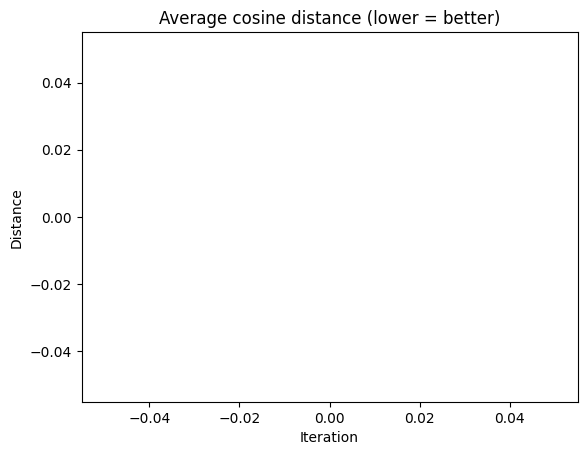

Diff failed: list index out of range


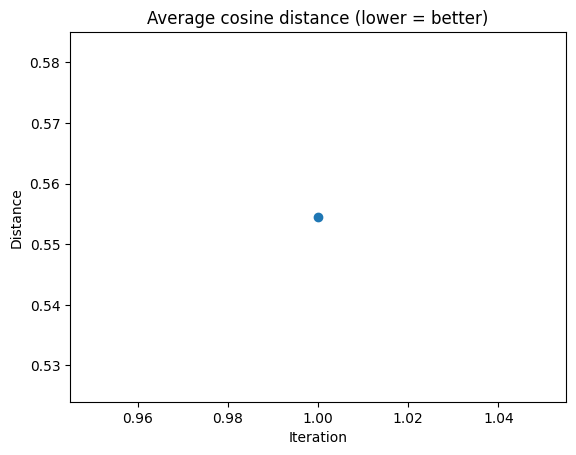

Iter 1: train 0.579 | val_old 0.555 → val_new 1.000  rejected
Iter 2: train 0.592 | val_old 0.547 → val_new 0.540  accepted
Iter 3: train 0.588 | val_old 0.546 → val_new 0.583  rejected
Iter 4: train 0.579 | val_old 0.490 → val_new 0.492  rejected
Iter 5: train 0.524 | val_old 0.595 → val_new 0.626  rejected
Iter 6: train 0.591 | val_old 0.590 → val_new 0.588  rejected
Iter 7: train 0.562 | val_old 0.559 → val_new 0.537  accepted
💫 Big improvement! Delta: 0.054
Iter 8: train 0.576 | val_old 0.644 → val_new 0.589  accepted
💫 Big improvement! Delta: 0.420
Iter 9: train 0.567 | val_old 1.000 → val_new 0.580  accepted
Iter 10: train 0.589 | val_old 0.517 → val_new 0.555  rejected
Iter 11: train 0.585 | val_old 0.539 → val_new 0.564  rejected
Iter 12: train 0.580 | val_old 0.598 → val_new 0.621  rejected
Iter 13: train 0.531 | val_old 0.589 → val_new 1.000  rejected
Iter 14: train 0.585 | val_old 0.564 → val_new 0.535  accepted
Iter 15: train 0.558 | val_old 0.637 → val_new 0.599  accepted


In [ ]:
# -----------------------------------------------------------------
# LOOP: persistent prompt, accept-if-better, live loss chart
# -----------------------------------------------------------------
import matplotlib.pyplot as plt
from IPython.display import clear_output

NUM_ITER     = 15          # number of optimisation rounds
BATCH_SIZE   = 30           # comments per train batch
VAL_SIZE     = 6           # comments per validation batch
MIN_IMPROVE  = 1e-3        # how much the val loss must drop
DIST_THRESH  = 0.20        # for critique bullet filter

current_prompt = user_prompt          # start from earlier prompt
loss_history   = []

plt.ion()
fig, ax = plt.subplots()
ax.set_title("Average cosine distance (lower = better)")
ax.set_xlabel("Iteration")
ax.set_ylabel("Distance")
line, = ax.plot([], [], marker="o")
display(fig)

improvement_history = []

for it in range(1, NUM_ITER + 1):
    # ----- sample train & val batches ---------------------------------
    train_rows = df.sample(BATCH_SIZE, random_state=100+it)
    val_rows   = df.sample(VAL_SIZE,   random_state=200+it)

# ------------------ helper --------------------------------------
    def run_batch(rows, prompt_text):
        target_block = "\n".join(f"- {r.comment}" for _, r in rows.iterrows())
        comp = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user",   "content": prompt_text +
                    "\n\nINSTRUCTIONS: For **each** comment below, "
                    "return one `reply_to_comment` function call, no text.\n\n" +
                    target_block}
            ],
            tools       = tools,
            tool_choice = "required",
        )
        tc_raw = [tc.model_dump() for tc in comp.choices[0].message.tool_calls]

        lookup = {r.comment.strip().casefold(): r.response
                  for _, r in rows.iterrows()}

        pairs, texts = [], []
        for tc in tc_raw:
            js   = json.loads(tc["function"]["arguments"])
            cmtN = js["comment"].strip().casefold()
            gt   = lookup.get(cmtN)
            if gt is None:
                continue
            gen  = js["reply"]
            pairs.append((gt, gen, js["comment"]))       # temp store
            texts.extend([gt, gen])

        if not pairs:
            return [], 1.0   # empty => worst loss

        emb = client.embeddings.create(
            model="text-embedding-3-small", input=texts).data
        vecs = [np.array(e.embedding, dtype=np.float32) for e in emb]

        dists = []
        new_pairs = []
        for i, (gt, gen, cmt) in enumerate(pairs):
            v_gt, v_gen = vecs[2*i], vecs[2*i+1]
            cos   = float(np.dot(v_gt, v_gen) /
                          (np.linalg.norm(v_gt)*np.linalg.norm(v_gen)))
            dist  = 1 - cos
            dists.append(dist)
            new_pairs.append((gt, gen, cmt, dist))

        return new_pairs, float(np.mean(dists))

# ------------------ loop snippet ---------------------------------
    # run on train batch
    train_pairs, train_loss = run_batch(train_rows, current_prompt)

    # ---- CRITIQUE & PATCH --------------------------------------------
    miss_pairs = [p for p in train_pairs if p[3] > DIST_THRESH]
    miss_block = "\n\n".join(
        f"Comment: {c}\nGT: {gt}\nGEN: {gen}\nDist: {d:.3f}"
        for gt, gen, c, d in miss_pairs) or "(none)"

    good_pairs = [p for p in train_pairs if p[3] < 0.10]
    good_block = "\n\n".join(
        f"Comment: {c}\nGT: {gt}\nGEN: {gen}\nDist: {d:.3f}"
        for gt, gen, c, d in good_pairs[:3]) or "(none)"

    crit_msg = client.chat.completions.create(
    model="gpt-4o",
    messages=[
        {"role":"system","content":"""You are an expert prompt engineer. Analyze response patterns and suggest targeted improvements.
Focus on:
- Specific patterns in mismatches (style, format, content)
- What the GT responses do that GEN responses miss
- Concrete, actionable prompt modifications
Return a unified diff that adds specific instructions or examples."""},
        {"role":"user","content":f"""
ORIGINAL_PROMPT
<
{current_prompt}
>>>

GOOD MATCHES (<0.10 distance):
{good_block}

MISMATCHES (>0.20 distance):
{miss_block}

Analyze the patterns. What do good responses have that bad ones lack?
Generate a unified diff that improves the prompt based on these patterns.
"""}],
    temperature=0.7,  # Higher for more creative suggestions
    max_tokens=1400
).choices[0].message.content.strip()

    patch_msg = crit_msg  # expecting unified diff
    try:
        merged_prompt = apply_unified_diff(current_prompt, patch_msg)
        if merged_prompt == current_prompt:
            print("Diff resulted in no changes")
    except Exception as e:
        print(f"Diff failed: {e}")
        # Try to extract suggestions manually
        if "add" in patch_msg.lower() or "insert" in patch_msg.lower():
            # Attempt simple append
            merged_prompt = current_prompt + "\n\n" + "Additional instructions: [extracted from critique]"
        else:
            merged_prompt = current_prompt

    # ---- validate ----------------------------------------------------
    _, val_old = run_batch(val_rows, current_prompt)
    _, val_new = run_batch(val_rows, merged_prompt)

    if len(loss_history) > 3:
        recent_variance = np.std(loss_history[-3:])
        MIN_IMPROVE = max(1e-4, min(1e-2, recent_variance * 0.5))

    improved = val_new < val_old - MIN_IMPROVE
    if improved:
        improvement_delta = val_old - val_new
        improvement_history.append({
            'iteration': it,
            'delta': improvement_delta,
            'critique': crit_msg,
            'patch': patch_msg
        })
        current_prompt = merged_prompt
        if improvement_delta > 0.05:  # Significant improvement
            print(f"💫 Big improvement! Delta: {improvement_delta:.3f}")

    # ---- logging & live plot ----------------------------------------
    loss_history.append(val_new if improved else val_old)

    line.set_data(range(1, len(loss_history)+1), loss_history)
    ax.relim(); ax.autoscale_view()
    fig.canvas.draw_idle()    # redraw *without* clearing
    plt.pause(0.001)        # (needed in notebooks)

    status = "accepted" if improved else "rejected"
    print(f"Iter {it}: train {train_loss:.3f} | "
          f"val_old {val_old:.3f} → val_new {val_new:.3f}  {status}")

print("\nFinal prompt:\n", current_prompt)


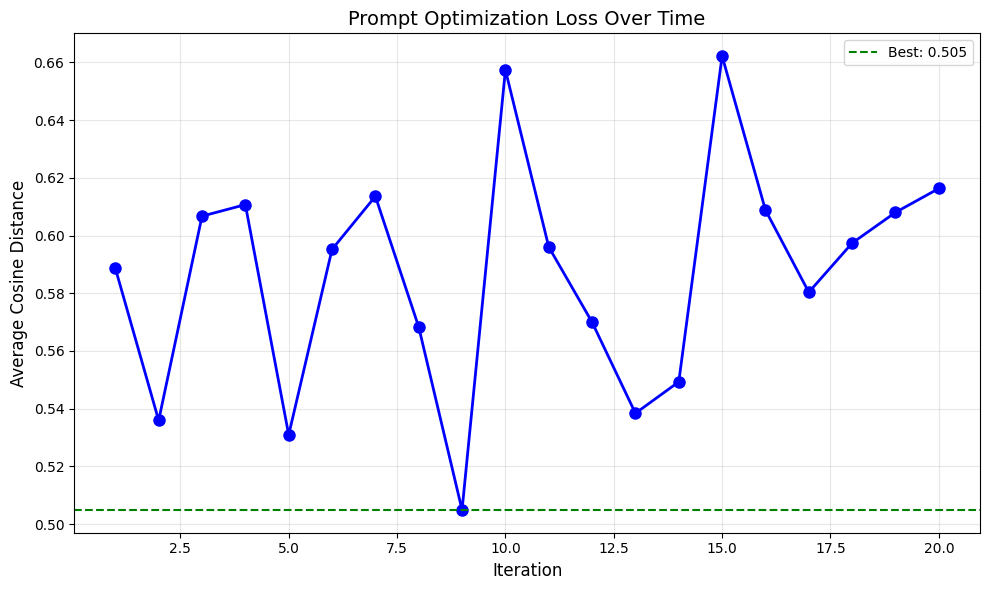


OPTIMIZATION COMPLETE
Starting loss: 0.589
Final loss: 0.616
Best loss: 0.505
Total improvement: 0.084

Best prompt achieved at iteration: 9

Best prompt saved to: /content/best_prompt.txt


In [ ]:
#@title Iterative Prompt Optimization Loop with Live Loss Graph

import os, random, textwrap, pandas as pd
from openai import OpenAI
import numpy as np, json, math
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time

os.environ["OPENAI_API_KEY"] = ""
CSV_PATH     = "/content/training_data.csv"
PROFILE_PATH = "/content/profile.txt"
N_EXEMPLARS  = 30
N_COMMENTS   =10
N_ITERATIONS = 20
DIST_THRESHOLD = 0.20

# ---- Load data --------------------------------------------------
df       = pd.read_csv(CSV_PATH)
profile  = open(PROFILE_PATH).read().strip()
client = OpenAI()

# ---- Define the function schema --------------------------------
tools = [{
    "type": "function",
    "function": {
        "name": "reply_to_comment",
        "description": "Return the persona-style reply to a single social-media comment.",
        "parameters": {
            "type": "object",
            "properties": {
                "comment": {"type": "string", "description": "Exact input comment"},
                "reply":   {"type": "string", "description": "Persona's reply, ≤50 words, emojis allowed"}
            },
            "required": ["comment", "reply"],
            "additionalProperties": False
        },
        "strict": True
    }
}]

# ---- Build initial system prompt --------------------------------
system_prompt = textwrap.dedent(f"""
    You are the social-media persona below.  Embody this voice completely:
    ===== PROFILE =====
    {profile}
    ===================
""").strip()

# ---- Initialize user prompt with exemplars ----------------------
exemplars = df.sample(min(N_EXEMPLARS, len(df)), random_state=0)
ex_block  = "\n\n".join(
    f"Comment: {r.comment}\nReply: {r.response}" for _, r in exemplars.iterrows()
)

user_prompt = textwrap.dedent(f"""
    Here are example replies in your style:

    {ex_block}

    Produce a reply for each of these comments (use function calls):
""").strip()

# ---- Helper functions -------------------------------------------
def apply_unified_diff(original: str, diff_text: str) -> str:
    """Apply a minimal unified-diff patch."""
    orig_lines = original.splitlines()
    new_lines  = []
    idx = 0
    for raw in diff_text.splitlines():
        line = raw.rstrip("\n")
        if line.startswith(("```", "---", "+++", "@@")) or line == "":
            continue
        if line.startswith(" "):
            new_lines.append(orig_lines[idx]); idx += 1
        elif line.startswith("-"):
            idx += 1
        elif line.startswith("+"):
            new_lines.append(line[1:])
        else:
            new_lines.append(line)
    new_lines.extend(orig_lines[idx:])
    return "\n".join(new_lines)

def evaluate_prompt(prompt, targets_df):
    """Evaluate a prompt on a set of target comments."""
    target_block = "\n".join(f"- {r.comment}" for _, r in targets_df.iterrows())

    try:
        completion = client.chat.completions.create(
            model = "gpt-4.1-mini",
            messages = [
                {"role":"system","content":prompt},
                {"role":"user",  "content":user_prompt + "\n" + target_block +
                            "\n\nINSTRUCTIONS: For **each** comment above, "
                            "return one `reply_to_comment` function call. "
                            "Do NOT reply with text, only tool calls."}
            ],
            tools       = tools,
            tool_choice = "required",
        )

        tool_calls = completion.choices[0].message.tool_calls
        if not tool_calls:
            print("WARNING: No tool calls returned!")
            return [], [], []

        tool_calls_raw = [tc.model_dump() for tc in tool_calls]

        # Ground-truth lookup
        gt_lookup = { r.comment: r.response for _, r in targets_df.iterrows() }

        # Collect pairs
        pairs = []
        for tc in tool_calls_raw:
            try:
                args = json.loads(tc["function"]["arguments"])
                cmt  = args.get("comment", "")
                gen  = args.get("reply", "")
                gt   = gt_lookup.get(cmt, None)

                # Skip if comment not found in ground truth
                if gt is None:
                    print(f"WARNING: Comment not found in ground truth: '{cmt[:50]}...'")
                    continue

                # Skip if any field is empty
                if not cmt or not gen or not gt:
                    print(f"WARNING: Empty field - comment: '{cmt[:30]}', reply: '{gen[:30]}', gt: '{gt[:30] if gt else 'None'}'")
                    continue

                pairs.append((gt, gen, cmt))
            except Exception as e:
                print(f"WARNING: Failed to parse tool call: {e}")
                continue

        if not pairs:
            print("ERROR: No valid pairs extracted!")
            return [], [], []

        # Embed everything
        flat_texts = []
        for p in pairs:
            # Ensure we have valid text for embedding
            gt_text = p[0].strip() if p[0] else "no ground truth"
            gen_text = p[1].strip() if p[1] else "no generation"

            # Ensure no empty strings
            if not gt_text:
                gt_text = "no ground truth"
            if not gen_text:
                gen_text = "no generation"

            flat_texts.extend([gt_text, gen_text])

        # Final check - remove any empty strings
        flat_texts = [t for t in flat_texts if t and t.strip()]

        if not flat_texts:
            print("ERROR: No texts to embed!")
            return [], [], []

        print(f"Embedding {len(flat_texts)} texts...")

        # Debug: print first few texts
        print(f"Sample texts to embed: {flat_texts[:4] if len(flat_texts) >= 4 else flat_texts}")

        emb_resp = client.embeddings.create(
                         model="text-embedding-3-small",
                         input=flat_texts
                     ).data
        vecs = [np.array(e.embedding, dtype=np.float32) for e in emb_resp]

        # Compute distances
        distances = []
        for i in range(len(pairs)):
            v_gt  = vecs[2*i]
            v_gen = vecs[2*i+1]
            cos   = float(np.dot(v_gt, v_gen) / (np.linalg.norm(v_gt)*np.linalg.norm(v_gen)))
            dist  = 1.0 - cos
            distances.append(dist)

        return pairs, vecs, distances

    except Exception as e:
        print(f"ERROR in evaluate_prompt: {type(e).__name__}: {e}")
        return [], [], []

# ---- Main optimization loop -------------------------------------
loss_history = []
prompt_history = [system_prompt]
best_prompt = system_prompt
best_loss = float('inf')

print("Starting iterative prompt optimization...\n")

for iteration in range(N_ITERATIONS):
    print(f"\n{'='*60}\nITERATION {iteration+1}/{N_ITERATIONS}\n{'='*60}")

    # Sample new test comments for this iteration
    targets = df.sample(min(N_COMMENTS, len(df)), random_state=iteration+100)

    # Evaluate current prompt
    pairs, vecs, distances = evaluate_prompt(system_prompt, targets)

    # Skip if evaluation failed
    if not distances:
        print("ERROR: Evaluation failed, skipping iteration...")
        continue

    avg_dist = sum(distances) / len(distances)
    loss_history.append(avg_dist)

    print(f"Current average distance: {avg_dist:.3f}")

    # Update best if improved
    if avg_dist < best_loss:
        best_loss = avg_dist
        best_prompt = system_prompt
        print(f"New best loss: {best_loss:.3f}")

    # Plot live graph
    clear_output(wait=True)
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(loss_history)+1), loss_history, 'b-o', linewidth=2, markersize=8)
    plt.axhline(y=best_loss, color='g', linestyle='--', label=f'Best: {best_loss:.3f}')
    plt.xlabel('Iteration', fontsize=12)
    plt.ylabel('Average Cosine Distance', fontsize=12)
    plt.title('Prompt Optimization Loss Over Time', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Skip critique on last iteration
    if iteration == N_ITERATIONS - 1:
        break

    # Collect misses for critique
    misses = [
        {
            "comment": pairs[i][2],
            "ground_truth": pairs[i][0],
            "generated": pairs[i][1],
            "distance": distances[i]
        }
        for i in range(len(pairs))
        if distances[i] > DIST_THRESHOLD
    ]

    if not misses:
        print("No misses above threshold, skipping critique...")
        continue

    miss_block = "\n\n".join(
        textwrap.dedent(f"""
        Comment: {m['comment']}
        GT      : {m['ground_truth']}
        Generated: {m['generated']}
        Cos-distance: {m['distance']:.3f}
        """).strip()
        for m in misses
    )

    # Generate critique
    crit_system = (
        "You are a prompt-engineer and strict evaluator.\n"
        "For every pair with cosine distance > 0.20, "
        "explain succinctly why the generated reply diverged.\n"
        "Inspect the *entire* system_prompt below and propose "
        "specific edits (wording, exemplar tweaks, additional rules) "
        "that would steer the model closer to the ground truth. "
        "Return ONE consolidated critique."
    )

    crit_user = textwrap.dedent(f"""
    ===== SYSTEM_PROMPT USED =====
    {system_prompt}
    ============================

    ===== MISMATCHED REPLIES (>0.20) =====
    {miss_block}
    ======================================

    Return suggested changes to the user prompt used based on the mismatched replies.

    Refer to the profile:
    ===== PROFILE =====
    {profile}
    ===================
    """).strip()

    print("\nGenerating critique...")
    try:
        crit_resp = client.chat.completions.create(
            model     = "gpt-4.1",  # Changed from gpt-4.1
            messages  = [
                {"role":"system","content":crit_system},
                {"role":"user",  "content":crit_user}
            ],
            temperature = 0.2,
            max_tokens  = 2000
        )
    except Exception as e:
        print(f"ERROR generating critique: {e}")
        continue

    # Generate diff
    diff_system = (
        "You are a prompt-engineer bot. Your job is to output a *unified diff* "
        "that transforms the ORIGINAL prompt into an IMPROVED prompt that "
        "incorporates the critique suggestions. Output ONLY the diff — no "
        "extra commentary."
    )

    diff_user = textwrap.dedent(f"""
    ORIGINAL_PROMPT <<<
    {system_prompt}
    >>>

    CRITIQUE_SUGGESTIONS <<<
    {crit_resp.choices[0].message.content.strip()}
    >>>

    Please produce a git-style unified diff (--- / +++) showing only the lines that change.
    """).strip()

    print("Generating diff...")
    try:
        diff_resp = client.chat.completions.create(
            model     = "gpt-4.1",  # Changed from gpt-4.1
            messages  = [
                {"role":"system","content":diff_system},
                {"role":"user",  "content":diff_user}
            ],
            temperature = 0.0,
            max_tokens  = 2000
        )
    except Exception as e:
        print(f"ERROR generating diff: {e}")
        continue

    patch = diff_resp.choices[0].message.content.strip()

    # Apply diff to create candidate prompt
    try:
        candidate_prompt = apply_unified_diff(system_prompt, patch)
    except Exception as e:
        print(f"ERROR applying diff: {e}")
        continue

    # Test candidate prompt on SAME targets
    print("\nTesting candidate prompt...")
    candidate_pairs, candidate_vecs, candidate_distances = evaluate_prompt(candidate_prompt, targets)

    # Skip if candidate evaluation failed
    if not candidate_distances:
        print("ERROR: Candidate evaluation failed, rejecting change...")
        continue

    candidate_avg_dist = sum(candidate_distances) / len(candidate_distances)

    print(f"Candidate average distance: {candidate_avg_dist:.3f}")
    print(f"Current average distance: {avg_dist:.3f}")

    # Accept or reject the change
    if candidate_avg_dist < avg_dist:
        system_prompt = candidate_prompt
        prompt_history.append(system_prompt)
        print(f"ACCEPTED: Improved by {avg_dist - candidate_avg_dist:.3f}")
    else:
        print(f"REJECTED: Would worsen by {candidate_avg_dist - avg_dist:.3f}")

    # Small delay to see progress
    time.sleep(0.5)

# Final summary
print(f"\n{'='*60}\nOPTIMIZATION COMPLETE\n{'='*60}")
print(f"Starting loss: {loss_history[0]:.3f}")
print(f"Final loss: {loss_history[-1]:.3f}")
print(f"Best loss: {best_loss:.3f}")
print(f"Total improvement: {loss_history[0] - best_loss:.3f}")
print(f"\nBest prompt achieved at iteration: {loss_history.index(best_loss) + 1}")

# Save best prompt
with open('/content/best_prompt.txt', 'w') as f:
    f.write(best_prompt)
print("\nBest prompt saved to: /content/best_prompt.txt")

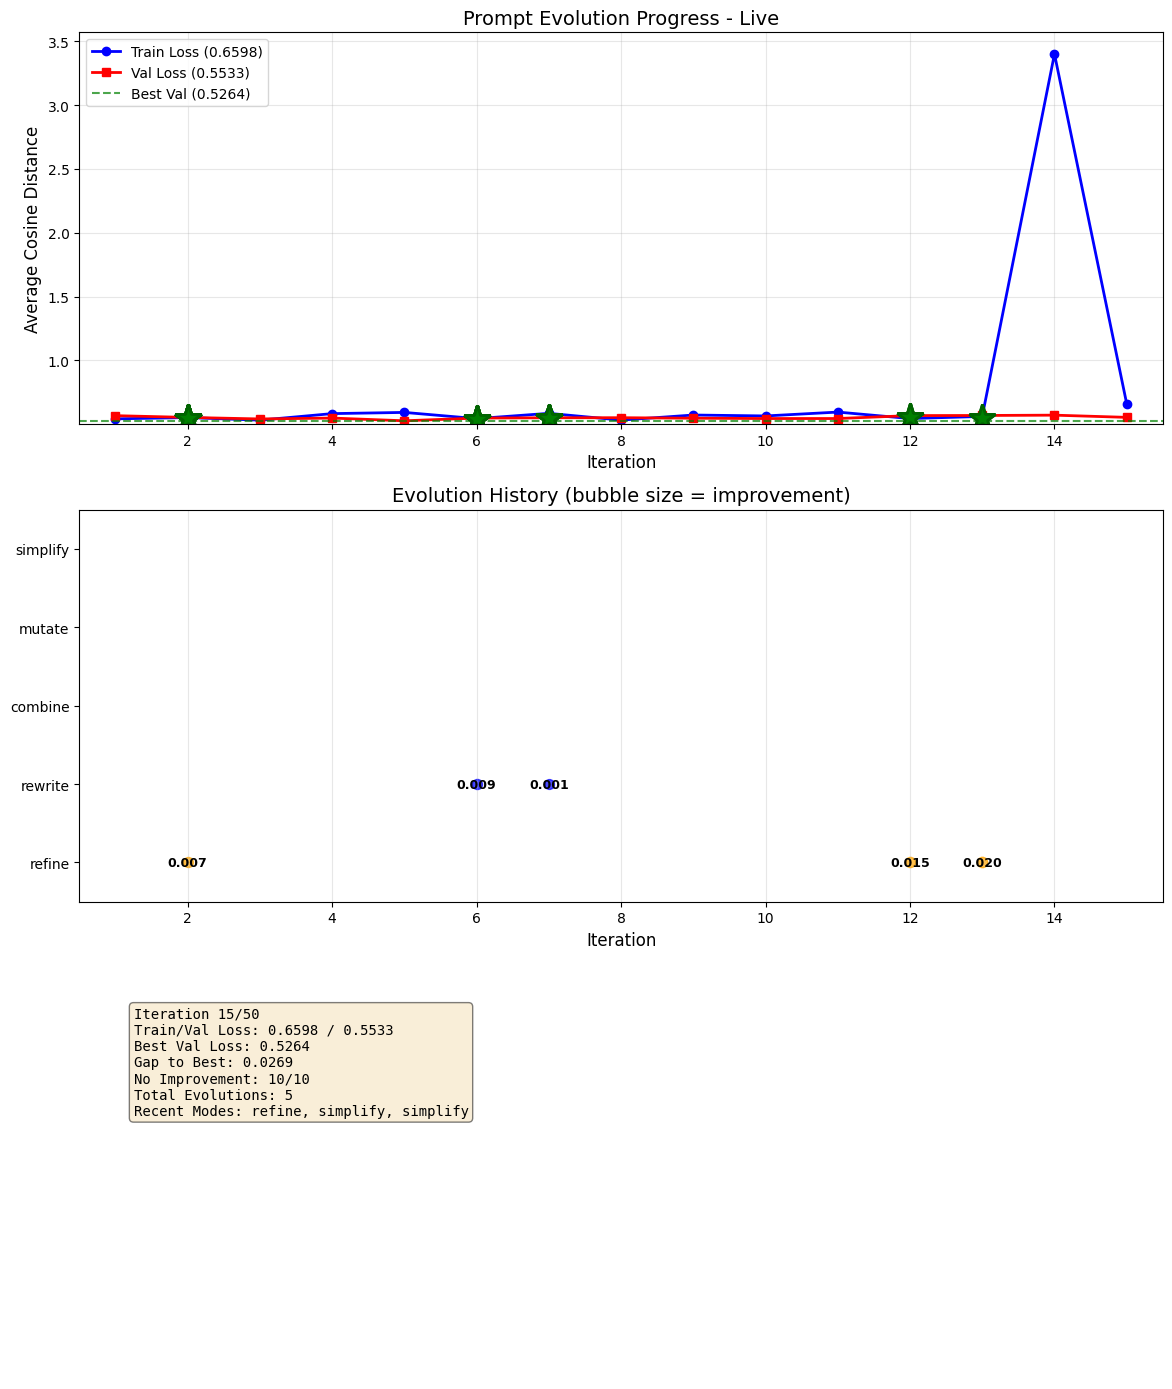


🛑 Early stopping after 10 iterations without improvement

EVOLUTION COMPLETE
Starting → Final loss: 0.5666 → 0.5533
Best loss achieved: 0.5264
Total improvement: 0.0401
Successful evolutions: 5

Evolution Summary:
  Iter 2: simplify → -0.0074
    The prompt was simplified by focusing directly on the persona (forbesricky) and clear instructions for comment replies (short, enthusiastic, under 50 words, with vivid emojis). This removes extraneous platform context, making the prompt more concise and action-oriented, which improves response clarity and relevance.
  Iter 6: refine → -0.0094
    The prompt was refined by replacing "enthusiastic" with "upbeat" to convey a more consistently positive tone, and specifying "storm-themed emojis" to better align with the storm chaser persona. These adjustments ensure replies are energetic yet focused, enhancing engagement and brand consistency.
  Iter 7: refine → -0.0008
    The prompt was refined to emphasize vividness and capturing the awe and po

In [ ]:
import os
import random
import textwrap
import pandas as pd
from openai import OpenAI
import numpy as np
import json
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
import time
from dataclasses import dataclass
from typing import List, Dict, Tuple, Optional

model_name = "gpt-4.1-mini"

# Try to set up interactive plotting
try:
    from IPython import get_ipython
    ipython = get_ipython()
    if ipython is not None:
        ipython.magic('matplotlib inline')
except:
    pass

# Configuration
@dataclass
class Config:
    csv_path: str = "/content/training_data.csv"
    profile_path: str = "/content/profile.txt"
    n_exemplars: int = 20
    train_size: int = 30
    val_size: int = 30
    n_iterations: int = 50
    dist_threshold: float = 0.20
    good_threshold: float = 0.10
    patience: int = 10
    min_improvement: float = 0.0001
    evolution_modes: List[str] = None

    def __post_init__(self):
        if self.evolution_modes is None:
            self.evolution_modes = ["refine", "rewrite", "combine", "mutate", "simplify"]

os.environ["OPENAI_API_KEY"] = ""


# Initialize configuration
config = Config()

# Load data
print("Loading data...")
df = pd.read_csv(config.csv_path)
with open(config.profile_path) as f:
    profile = f.read().strip()

# Initialize OpenAI client
client = OpenAI()

# Create fixed validation set
print(f"Creating fixed validation set with {config.val_size} examples...")
val_df = df.sample(config.val_size, random_state=42)
train_pool_df = df.drop(val_df.index)
print(f"Training pool size: {len(train_pool_df)}, Validation size: {len(val_df)}")

# Define the function schema
tools = [{
    "type": "function",
    "function": {
        "name": "reply_to_comment",
        "description": "Return the persona-style reply to a single social-media comment.",
        "parameters": {
            "type": "object",
            "properties": {
                "comment": {"type": "string", "description": "Exact input comment"},
                "reply": {"type": "string", "description": "Persona's reply, ≤50 words, emojis allowed"}
            },
            "required": ["comment", "reply"],
            "additionalProperties": False
        },
        "strict": True
    }
}]

# Data structures
@dataclass
class EvaluationResult:
    pairs: List[Tuple[str, str, str]]  # (ground_truth, generated, comment)
    distances: List[float]
    avg_distance: float
    num_failures: int

@dataclass
class EvolutionRecord:
    iteration: int
    mode: str
    old_loss: float
    new_loss: float
    improvement: float
    system_prompt: str
    explanation: str

class LivePlotter:
    """Handle live updating plots during optimization"""

    def __init__(self):
        # Create figure with subplots
        self.fig, (self.ax1, self.ax2, self.ax3) = plt.subplots(3, 1, figsize=(12, 14))

        # Initialize loss plot
        self.train_line, = self.ax1.plot([], [], 'b-o', linewidth=2, markersize=6, label='Train Loss')
        self.val_line, = self.ax1.plot([], [], 'r-s', linewidth=2, markersize=6, label='Val Loss')
        self.best_line = self.ax1.axhline(y=0, color='g', linestyle='--', alpha=0.7, label='Best Val')
        self.ax1.set_xlabel('Iteration', fontsize=12)
        self.ax1.set_ylabel('Average Cosine Distance', fontsize=12)
        self.ax1.set_title('Prompt Evolution Progress - Live', fontsize=14)
        self.ax1.grid(True, alpha=0.3)
        self.ax1.legend(loc='upper right')

        # Initialize evolution timeline
        self.ax2.set_xlabel('Iteration', fontsize=12)
        self.ax2.set_ylabel('Evolution Mode', fontsize=12)
        self.ax2.set_title('Evolution History', fontsize=14)
        self.ax2.grid(True, alpha=0.3, axis='x')

        # Initialize status text area
        self.ax3.axis('off')
        self.status_text = self.ax3.text(0.05, 0.95, '', transform=self.ax3.transAxes,
                                         fontsize=10, verticalalignment='top',
                                         fontfamily='monospace',
                                         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

        plt.tight_layout()

        # Data storage
        self.train_losses = []
        self.val_losses = []
        self.evolutions = []

    def update(self, iteration: int, train_loss: float, val_loss: float,
               best_val_loss: float, evolutions: List[EvolutionRecord],
               status_text: str = ""):
        """Update the live plot with new data"""

        # Clear output for live update
        clear_output(wait=True)

        # Store data
        self.train_losses.append(train_loss)
        self.val_losses.append(val_loss)
        iterations = list(range(1, len(self.train_losses) + 1))

        # Update loss lines
        self.train_line.set_data(iterations, self.train_losses)
        self.val_line.set_data(iterations, self.val_losses)

        # Update best line
        self.best_line.set_ydata([best_val_loss, best_val_loss])
        self.ax1.legend([f'Train Loss ({train_loss:.4f})',
                        f'Val Loss ({val_loss:.4f})',
                        f'Best Val ({best_val_loss:.4f})'])

        # Update axis limits
        if self.train_losses:
            all_losses = self.train_losses + self.val_losses
            y_min = min(all_losses) * 0.95
            y_max = max(all_losses) * 1.05
            self.ax1.set_xlim(0.5, len(iterations) + 0.5)
            self.ax1.set_ylim(y_min, y_max)

        # Mark successful evolutions
        for evo in evolutions:
            self.ax1.plot(evo.iteration + 1, evo.new_loss, 'g*',
                         markersize=20, markeredgecolor='darkgreen', markeredgewidth=2)

        # Update evolution timeline
        self.ax2.clear()
        if evolutions:
            mode_colors = {
                'refine': 'blue',
                'rewrite': 'red',
                'combine': 'green',
                'mutate': 'purple',
                'simplify': 'orange'
            }

            for evo in evolutions:
                color = mode_colors.get(evo.mode, 'gray')
                self.ax2.scatter(evo.iteration + 1, evo.mode,
                               s=300 * evo.improvement + 50,
                               c=color, alpha=0.7)
                self.ax2.text(evo.iteration + 1, evo.mode,
                            f'{evo.improvement:.3f}',
                            ha='center', va='center', fontsize=9, fontweight='bold')

        self.ax2.set_xlim(0.5, max(len(iterations), 10) + 0.5)
        self.ax2.set_ylim(-0.5, len(config.evolution_modes) - 0.5)
        self.ax2.set_yticks(range(len(config.evolution_modes)))
        self.ax2.set_yticklabels(config.evolution_modes)
        self.ax2.set_xlabel('Iteration', fontsize=12)
        self.ax2.set_title('Evolution History (bubble size = improvement)', fontsize=14)
        self.ax2.grid(True, alpha=0.3, axis='x')

        # Update status text
        self.status_text.set_text(status_text)

        # Display the plot
        display(self.fig)

    def close(self):
        """Close the plot"""
        plt.close(self.fig)

# Helper functions
def create_initial_system_prompt(profile: str, exemplar_df: pd.DataFrame) -> str:
    """Create initial system prompt with examples embedded"""

    ex_block = "\n\n".join(
        f"Comment: {r.comment}\nReply: {r.response}"
        for _, r in exemplar_df.iterrows()
    )

    system_prompt = textwrap.dedent(f"""
    You are a social media persona with this profile:

    {profile}

    CRITICAL INSTRUCTIONS:
    1. Match the EXACT style, tone, and personality shown in these examples
    2. Keep all responses under 50 words
    3. Use emojis only if they fit the persona's style

    STUDY THESE EXAMPLES - they define your voice:

    {ex_block}

    Now embody this persona completely. Reply to comments in this EXACT style.
    """).strip()

    return system_prompt

def evaluate_prompt(system_prompt: str, targets_df: pd.DataFrame,
                   model: str = model_name) -> Optional[EvaluationResult]:
    """Evaluate a system prompt on target comments"""

    target_block = "\n".join(f"- {r.comment}" for _, r in targets_df.iterrows())

    try:
        completion = client.chat.completions.create(
            model=model,
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": (
                    f"Reply to each of these comments:\n{target_block}\n\n"
                    "For each comment, use the reply_to_comment function. No other text."
                )}
            ],
            tools=tools,
            tool_choice="required",
        )

        tool_calls = completion.choices[0].message.tool_calls
        if not tool_calls:
            return None

        # Process tool calls
        gt_lookup = {r.comment: r.response for _, r in targets_df.iterrows()}
        pairs = []

        for tc in tool_calls:
            try:
                args = json.loads(tc.function.arguments)
                comment = args.get("comment", "").strip()
                generated = args.get("reply", "").strip()
                ground_truth = gt_lookup.get(comment)

                if ground_truth and comment and generated:
                    pairs.append((ground_truth, generated, comment))
            except:
                continue

        if not pairs:
            return None

        # Compute embeddings and distances
        texts_to_embed = []
        for gt, gen, _ in pairs:
            texts_to_embed.extend([gt, gen])

        emb_resp = client.embeddings.create(
            model="text-embedding-3-small",
            input=texts_to_embed
        )

        vecs = [np.array(e.embedding, dtype=np.float32) for e in emb_resp.data]

        distances = []
        for i in range(len(pairs)):
            v_gt = vecs[2*i]
            v_gen = vecs[2*i+1]
            cos_sim = np.dot(v_gt, v_gen) / (np.linalg.norm(v_gt) * np.linalg.norm(v_gen))
            distances.append(1.0 - cos_sim)

        avg_dist = np.mean(distances)
        num_failures = len(targets_df) - len(pairs)

        # Penalize incomplete responses
        if num_failures > 0:
            penalty = num_failures * 0.1
            avg_dist = avg_dist + penalty

        return EvaluationResult(
            pairs=pairs,
            distances=distances,
            avg_distance=avg_dist,
            num_failures=num_failures
        )

    except Exception as e:
        print(f"ERROR in evaluate_prompt: {e}")
        return None

def analyze_results(result: EvaluationResult) -> Dict[str, any]:
    """Deep analysis of what's working and what's not"""

    good_responses = []
    bad_responses = []

    for i, (gt, gen, comment) in enumerate(result.pairs):
        entry = {
            'comment': comment,
            'generated': gen,
            'ground_truth': gt,
            'distance': result.distances[i]
        }

        if result.distances[i] < config.good_threshold:
            good_responses.append(entry)
        elif result.distances[i] > config.dist_threshold:
            bad_responses.append(entry)

    # Analyze patterns
    analysis = {
        'good_responses': good_responses[:3],  # Top 3
        'bad_responses': bad_responses[:5],    # Top 5 worst
        'avg_good_length': np.mean([len(r['generated'].split()) for r in good_responses]) if good_responses else 0,
        'avg_bad_length': np.mean([len(r['generated'].split()) for r in bad_responses]) if bad_responses else 0,
        'avg_gt_length': np.mean([len(r['ground_truth'].split()) for r in good_responses + bad_responses]),
        'good_emoji_rate': np.mean([1 if any(ord(c) > 127 for c in r['generated']) else 0 for r in good_responses]) if good_responses else 0,
        'bad_emoji_rate': np.mean([1 if any(ord(c) > 127 for c in r['generated']) else 0 for r in bad_responses]) if bad_responses else 0,
        'common_mistakes': identify_common_mistakes(bad_responses),
        'success_patterns': identify_success_patterns(good_responses)
    }

    return analysis

def identify_common_mistakes(bad_responses: List[Dict]) -> List[str]:
    """Identify patterns in failed responses"""
    mistakes = []

    if not bad_responses:
        return mistakes

    # Check length issues
    avg_bad_len = np.mean([len(r['generated'].split()) for r in bad_responses])
    avg_gt_len = np.mean([len(r['ground_truth'].split()) for r in bad_responses])
    if avg_bad_len > avg_gt_len * 1.5:
        mistakes.append("Responses too long/verbose")
    elif avg_bad_len < avg_gt_len * 0.5:
        mistakes.append("Responses too short/terse")

    # Check formality
    formal_indicators = ['thank you', 'please', 'would you', 'could you', 'appreciate']
    if sum(1 for r in bad_responses if any(ind in r['generated'].lower() for ind in formal_indicators)) > len(bad_responses) * 0.5:
        mistakes.append("Too formal/polite")

    # Check emoji usage
    emoji_in_gt = sum(1 for r in bad_responses if any(ord(c) > 127 for c in r['ground_truth']))
    emoji_in_gen = sum(1 for r in bad_responses if any(ord(c) > 127 for c in r['generated']))
    if emoji_in_gt > len(bad_responses) * 0.5 and emoji_in_gen < len(bad_responses) * 0.2:
        mistakes.append("Missing emojis when persona uses them")

    return mistakes

def identify_success_patterns(good_responses: List[Dict]) -> List[str]:
    """Identify what makes responses successful"""
    patterns = []

    if not good_responses:
        return patterns

    # Analyze what's working
    if len(good_responses) >= 3:
        # Check consistency
        gen_lengths = [len(r['generated'].split()) for r in good_responses]
        gt_lengths = [len(r['ground_truth'].split()) for r in good_responses]
        if np.std(gen_lengths) < 3 and abs(np.mean(gen_lengths) - np.mean(gt_lengths)) < 2:
            patterns.append("Consistent response length matching ground truth")

        # Check style matching
        if all(any(ord(c) > 127 for c in r['generated']) == any(ord(c) > 127 for c in r['ground_truth'])
               for r in good_responses):
            patterns.append("Emoji usage matches ground truth pattern")

    return patterns

def evolve_prompt(current_prompt: str, analysis: Dict, evolution_mode: str,
                  profile: str, exemplar_df: pd.DataFrame) -> Tuple[str, str]:
    """Evolve the prompt using different strategies"""

    evolution_instructions = {
        "refine": """Based on the analysis, make targeted improvements to fix the identified mistakes
                     while preserving what's working. Make minimal but impactful changes.""",

        "rewrite": """Completely rewrite the prompt from scratch to better capture the persona.
                      Focus on the core personality traits and communication style.
                      Be bold - create a fundamentally different approach.""",

        "combine": """Create a hybrid approach that combines the current prompt's structure
                      with new elements inspired by the successful patterns.
                      Add specific rules or constraints based on the analysis.""",

        "mutate": """Make unexpected creative changes to the prompt. Try unconventional approaches like:
                     - Role-playing instructions
                     - Specific linguistic constraints
                     - Personality quirks or catchphrases
                     - Emotional state descriptions""",

        "simplify": """Strip the prompt down to its essential elements. Remove anything that might
                       be confusing or contradictory. Focus on clarity and directness."""
    }

    # Format good and bad examples
    good_examples = "\n\n".join([
        f"Comment: {r['comment']}\nGood Response: {r['generated']}\nTarget: {r['ground_truth']}\nDistance: {r['distance']:.3f}"
        for r in analysis['good_responses']
    ]) or "No good examples yet"

    bad_examples = "\n\n".join([
        f"Comment: {r['comment']}\nBad Response: {r['generated']}\nTarget: {r['ground_truth']}\nDistance: {r['distance']:.3f}"
        for r in analysis['bad_responses']
    ]) or "No bad examples"

    messages = [
        {"role": "system", "content": "You are an expert prompt engineer specializing in persona matching."},
        {"role": "user", "content": f"""
EVOLUTION MODE: {evolution_mode}
{evolution_instructions[evolution_mode]}

CURRENT PROMPT:
{current_prompt}

PROFILE TO MATCH:
{profile}

ANALYSIS:
- Common Mistakes: {', '.join(analysis['common_mistakes']) or 'None identified'}
- Success Patterns: {', '.join(analysis['success_patterns']) or 'None identified'}
- Avg Good Length: {analysis['avg_good_length']:.1f} words
- Avg Bad Length: {analysis['avg_bad_length']:.1f} words
- Target Avg Length: {analysis['avg_gt_length']:.1f} words

GOOD MATCHES:
{good_examples}

BAD MATCHES:
{bad_examples}

Create an evolved system prompt that will better match this persona.
Return ONLY the new prompt text, nothing else.
"""}
    ]

    response = client.chat.completions.create(
        model=model_name,
        messages=messages,
        temperature=0.7 if evolution_mode in ["mutate", "rewrite"] else 0.3,
        max_tokens=2000
    )

    new_prompt = response.choices[0].message.content.strip()

    # Generate explanation
    explain_messages = [
        {"role": "system", "content": "Explain prompt changes concisely."},
        {"role": "user", "content": f"""
Old prompt: {current_prompt[:200]}...
New prompt: {new_prompt[:200]}...
Evolution mode: {evolution_mode}

In 2-3 sentences, explain the key changes made and why they should help.
"""}
    ]

    explain_response = client.chat.completions.create(
        model=model_name,
        messages=explain_messages,
        max_tokens=200
    )

    explanation = explain_response.choices[0].message.content.strip()

    return new_prompt, explanation

# Main optimization loop
def run_optimization():
    """Main optimization loop with true prompt evolution"""

    # Initialize with examples in system prompt
    exemplar_df = train_pool_df.sample(min(config.n_exemplars, len(train_pool_df)), random_state=0)
    current_prompt = create_initial_system_prompt(profile, exemplar_df)

    # Tracking variables
    train_losses = []
    val_losses = []
    evolutions = []
    best_prompt = current_prompt
    best_val_loss = float('inf')
    no_improvement_count = 0
    evolution_history = []

    # Initialize live plotter
    plotter = LivePlotter()

    print("Starting prompt evolution...\n")

    for iteration in range(config.n_iterations):
        print(f"\n{'='*70}")
        print(f"ITERATION {iteration+1}/{config.n_iterations}")
        print(f"{'='*70}")

        # Sample training batch
        train_batch = train_pool_df.sample(
            min(config.train_size, len(train_pool_df)),
            random_state=iteration+1000
        )

        # Evaluate current prompt
        print("Evaluating current prompt...")
        train_result = evaluate_prompt(current_prompt, train_batch)
        if not train_result:
            print("ERROR: Training evaluation failed")
            continue

        val_result = evaluate_prompt(current_prompt, val_df)
        if not val_result:
            print("ERROR: Validation evaluation failed")
            continue

        # Record losses
        train_losses.append(train_result.avg_distance)
        val_losses.append(val_result.avg_distance)

        print(f"Train loss: {train_result.avg_distance:.4f}")
        print(f"Val loss: {val_result.avg_distance:.4f}")

        # Check for improvement
        if val_result.avg_distance < best_val_loss - config.min_improvement:
            improvement = best_val_loss - val_result.avg_distance
            best_val_loss = val_result.avg_distance
            best_prompt = current_prompt
            no_improvement_count = 0
            print(f"New best! Improvement: {improvement:.4f}")

            # Save best
            with open(f'/content/best_prompt_iter{iteration+1}.txt', 'w') as f:
                f.write(f"Iteration: {iteration+1}\n")
                f.write(f"Val Loss: {best_val_loss:.4f}\n\n")
                f.write(best_prompt)
        else:
            no_improvement_count += 1
            print(f"No improvement for {no_improvement_count} iterations")

        # Update live plot
        status_text = f"""Iteration {iteration+1}/{config.n_iterations}
Train/Val Loss: {train_result.avg_distance:.4f} / {val_result.avg_distance:.4f}
Best Val Loss: {best_val_loss:.4f}
Gap to Best: {val_result.avg_distance - best_val_loss:.4f}
No Improvement: {no_improvement_count}/{config.patience}
Total Evolutions: {len(evolutions)}
Recent Modes: {', '.join([e.mode for e in evolutions[-3:]])}"""

        plotter.update(
            iteration=iteration,
            train_loss=train_result.avg_distance,
            val_loss=val_result.avg_distance,
            best_val_loss=best_val_loss,
            evolutions=evolutions,
            status_text=status_text
        )

        # Early stopping
        if no_improvement_count >= config.patience:
            print(f"\n🛑 Early stopping after {config.patience} iterations without improvement")
            break

        # Skip evolution on last iteration
        if iteration == config.n_iterations - 1:
            break

        # Analyze current performance
        print("\nAnalyzing performance...")
        analysis = analyze_results(train_result)

        print(f"Common mistakes: {', '.join(analysis['common_mistakes']) or 'None'}")
        print(f"Success patterns: {', '.join(analysis['success_patterns']) or 'None'}")

        # Choose evolution mode
        if no_improvement_count > 5:
            # Aggressive modes when stuck
            mode = random.choice(["rewrite", "mutate"])
        elif no_improvement_count > 2:
            # Exploration modes
            mode = random.choice(["combine", "mutate", "simplify"])
        else:
            # Normal refinement
            mode = "refine"

        # Allow override based on analysis
        if "too long" in str(analysis['common_mistakes']).lower():
            mode = "simplify"
        elif len(analysis['common_mistakes']) > 3:
            mode = "rewrite"

        print(f"\n🧬 Evolution mode: {mode.upper()}")

        # Evolve the prompt
        candidate_prompt, explanation = evolve_prompt(
            current_prompt, analysis, mode, profile, exemplar_df
        )

        print(f"Evolution explanation: {explanation}")

        # Test candidate
        print("\nTesting evolved prompt...")
        candidate_train = evaluate_prompt(candidate_prompt, train_batch)
        candidate_val = evaluate_prompt(candidate_prompt, val_df)

        if not candidate_train or not candidate_val:
            print("ERROR: Candidate evaluation failed")
            continue

        print(f"Candidate train/val: {candidate_train.avg_distance:.4f} / {candidate_val.avg_distance:.4f}")
        print(f"Delta: {candidate_val.avg_distance - val_result.avg_distance:+.4f}")

        # Accept or reject
        if candidate_val.avg_distance < val_result.avg_distance - config.min_improvement:
            improvement = val_result.avg_distance - candidate_val.avg_distance
            current_prompt = candidate_prompt

            evolutions.append(EvolutionRecord(
                iteration=iteration,
                mode=mode,
                old_loss=val_result.avg_distance,
                new_loss=candidate_val.avg_distance,
                improvement=improvement,
                system_prompt=candidate_prompt[:200] + "...",
                explanation=explanation
            ))

            print(f"ACCEPTED: Improved by {improvement:.4f}")
        else:
            print(f"REJECTED: Would worsen by {candidate_val.avg_distance - val_result.avg_distance:.4f}")

            # Track failed attempts
            evolution_history.append({
                'iteration': iteration,
                'mode': mode,
                'rejected': True,
                'delta': candidate_val.avg_distance - val_result.avg_distance
            })

        time.sleep(0.2)

    # Close plotter
    plotter.close()

    # Final summary
    print(f"\n{'='*70}")
    print("EVOLUTION COMPLETE")
    print(f"{'='*70}")

    print(f"Starting → Final loss: {val_losses[0]:.4f} → {val_losses[-1]:.4f}")
    print(f"Best loss achieved: {best_val_loss:.4f}")
    print(f"Total improvement: {val_losses[0] - best_val_loss:.4f}")
    print(f"Successful evolutions: {len(evolutions)}")

    if evolutions:
        print(f"\nEvolution Summary:")
        for evo in evolutions:
            print(f"  Iter {evo.iteration+1}: {evo.mode} → -{evo.improvement:.4f}")
            print(f"    {evo.explanation}")

    # Final analysis
    print(f"\nFinal Performance Analysis:")
    final_result = evaluate_prompt(best_prompt, val_df)
    if final_result:
        final_analysis = analyze_results(final_result)

        # Show best/worst examples
        sorted_pairs = sorted(zip(final_result.pairs, final_result.distances), key=lambda x: x[1])
        if sorted_pairs:
            print(f"\nBest match (distance: {sorted_pairs[0][1]:.4f}):")
            print(f"  Comment: {sorted_pairs[0][0][2]}")
            print(f"  Generated: {sorted_pairs[0][0][1]}")

            print(f"\nWorst match (distance: {sorted_pairs[-1][1]:.4f}):")
            print(f"  Comment: {sorted_pairs[-1][0][2]}")
            print(f"  Generated: {sorted_pairs[-1][0][1]}")

    # Save final prompt
    with open('/content/best_evolved_prompt.txt', 'w') as f:
        f.write(f"Final Best Loss: {best_val_loss:.4f}\n")
        f.write(f"Total Evolutions: {len(evolutions)}\n\n")
        f.write("=== EVOLVED SYSTEM PROMPT ===\n\n")
        f.write(best_prompt)

    print("\n💾 Best evolved prompt saved to: /content/best_evolved_prompt.txt")

    return best_prompt, val_losses, evolutions

# Run the optimization
if __name__ == "__main__":
    best_prompt, history, evolutions = run_optimization()